In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from data_utils.dataset import ChangeDetectionDataset
from utils.models import FCSiamDiff, FCEF


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_dataset = ChangeDetectionDataset(train_dir, data_transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataset = ChangeDetectionDataset(val_dir, data_transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = ChangeDetectionDataset(test_dir, data_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

lr = 3e-4
num_epoches = 6

net = FCSiamDiff().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr)

loss_func = nn.BCEWithLogitsLoss()

In [2]:
l_his = []

for epoch in range(num_epoches):
    print("Epoch:", epoch + 1, "Training...")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        x, labels = (
            Variable(x),
            Variable(labels.float()),
        )

        optimizer.zero_grad()
        f1 = net(x)
        loss = loss_func(f1, labels)
        loss.backward()
        optimizer.step()
        if i % 5 == 4:
            l_his.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1 Training...
[1,    50] loss: 0.255
[1,   100] loss: 0.239
[1,   150] loss: 0.231
[1,   200] loss: 0.226
[1,   250] loss: 0.222
[1,   300] loss: 0.218
[1,   350] loss: 0.212
[1,   400] loss: 0.208
[1,   450] loss: 0.203
[1,   500] loss: 0.199
[1,   550] loss: 0.193
[1,   600] loss: 0.191
[1,   650] loss: 0.185
[1,   700] loss: 0.185
[1,   750] loss: 0.181
[1,   800] loss: 0.173
[1,   850] loss: 0.171
Epoch: 2 Training...
[2,    50] loss: 0.166
[2,   100] loss: 0.160
[2,   150] loss: 0.156
[2,   200] loss: 0.154
[2,   250] loss: 0.150
[2,   300] loss: 0.150
[2,   350] loss: 0.146
[2,   400] loss: 0.142
[2,   450] loss: 0.141
[2,   500] loss: 0.140
[2,   550] loss: 0.132
[2,   600] loss: 0.131
[2,   650] loss: 0.130
[2,   700] loss: 0.125
[2,   750] loss: 0.126
[2,   800] loss: 0.127
[2,   850] loss: 0.122
Epoch: 3 Training...
[3,    50] loss: 0.118
[3,   100] loss: 0.116
[3,   150] loss: 0.114
[3,   200] loss: 0.114
[3,   250] loss: 0.114
[3,   300] loss: 0.106
[3,   350] loss: 

Finished Training


Text(0, 0.5, 'Loss')

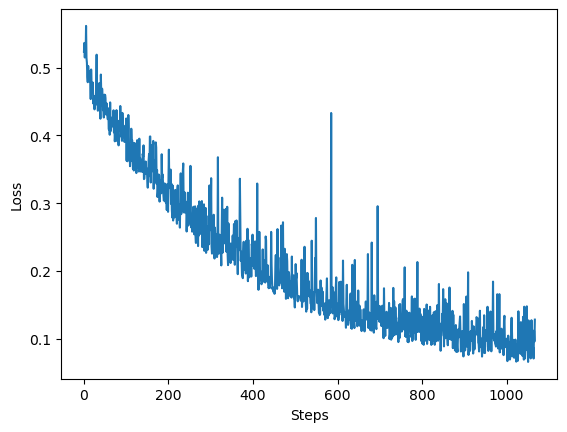

In [3]:

print("Finished Training")
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(l_his)
plt.xlabel("Steps")
plt.ylabel("Loss")

In [4]:
import torchmetrics

metrics = torchmetrics.metric_collection = torchmetrics.MetricCollection({
    'IoU': torchmetrics.JaccardIndex(task='binary'),
    'F1': torchmetrics.F1Score(task='binary', average='macro')
}).to(device)

for i, data in enumerate(val_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)


        with torch.no_grad():
            f1 = net(x)
            metrics(f1, labels)
            f1 = torch.round(torch.sigmoid(f1)).cpu().detach().numpy()

        # Disply results
        # for i in range(batch_size):
        #     plt.figure()
        #     fig, (ax1, ax2) = plt.subplots(1, 2)
        #     ax1.imshow(f1[i][0], cmap='gray')
        #     plt.figure()
        #     ax2.imshow(labels.cpu().numpy()[i][0], cmap='gray')
        #     plt.show(block=False)

results = metrics.compute()
print(results)

{'F1': tensor(0.7060, device='cuda:0'), 'IoU': tensor(0.5456, device='cuda:0')}
